In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot

np.set_printoptions(precision = 4)
tf.random.set_seed(42)

2023-01-27 15:39:48.372704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def queryRangePostCode(df_power, consumption_range = 2500, post_code = 81737, rank_range = (1,5)) -> pd.DataFrame:

    res = df_power.loc[(df_power['rank'] >= rank_range[0]) & (df_power['rank'] <= rank_range[1]) & (df_power.post_code == post_code) & (df_power.consumption_range_kwh == consumption_range)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

# Baseline Model shifting the label by the forecasting horizon

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


MAX_EPOCHS = 10
error_metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]

def compile_and_fit(model, window, error_metrics = error_metrics, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    verbose = 0)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=error_metrics)

  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=early_stopping, shuffle = True, verbose = 0)
  return history

In [3]:
pathes_household = {"gas": "./data/Generated Data/master_competitor_market_prices_gas.csv", 
                    "power": "./data/Generated Data/master_competitor_market_prices_power.csv"}
pathes_market = {"gas": "./data/Generated Data/gas_prices.csv", 
                 "power": "./data/Generated Data/power_prices.csv"}

In [420]:
energy = "power"

path_household = pathes_household[energy]
path_market = pathes_market[energy]

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_household, usecols=usecols, dtype = dtypes)
market_data = pd.read_csv(path_market, header = [0], parse_dates=["Dates"])

market_data.set_index("Dates", inplace = True)
market_data["moving_average"] = market_data.avg_price.ewm(alpha=0.1, adjust=False).mean()
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [62]:
norm_layer = tf.keras.layers.Normalization(axis = 1)
consRange = 2000
postCode = "81737"

input = queryRangePostCode(household, consumption_range=consRange, post_code=postCode, rank_range=[6,10])
input = input.join(market_data[["avg_price", "moving_average"]]).interpolate(method = "time", axis = 0)
norm_layer.adapt(input)
norm_input = norm_layer(input)
norm_input = pd.DataFrame(norm_input, columns = input.columns, index = input.index)

In [219]:
shift = 5
input_width = 10

train_df = norm_input[:-shift]
val_df = norm_input[-(2*shift+input_width):]

In [220]:
print(train_df.shape)
print(val_df.shape)

(415, 3)
(24, 3)


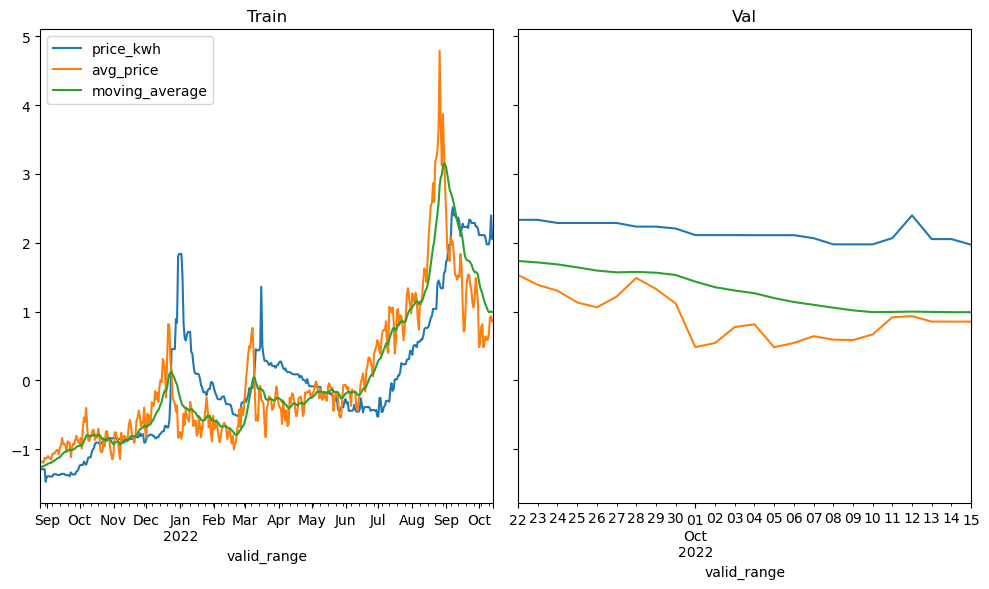

In [221]:
fig, (ax1, ax2) = plt.subplots(1,2, 
                               figsize = (10,6), 
                               #gridspec_kw={'width_ratios': [train_size, 1-train_size]}, 
                               sharey= "row")

ax1 = train_df.plot(ax = ax1, legend = True)
ax2 = val_df.plot(ax = ax2, legend = False)
ax1.set_title("Train")
ax2.set_title("Val")
fig.tight_layout()

# Definition

In [268]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=shift,
    label_columns=['price_kwh'], train_df=train_df, val_df=val_df)

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [269]:
multi_in_multi_out = WindowGenerator(
    input_width=input_width,
    label_width=input_width,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

multi_in_multi_out

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['price_kwh']

In [270]:
multi_in_single_out = WindowGenerator(
    input_width=input_width,
    label_width=1,
    shift=shift,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df)

multi_in_single_out

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['price_kwh']

# Model Declaration

In [ ]:
baseline = Baseline(label_index=0)

In [356]:
# Dense NN with single step

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [357]:
# Dense Neural Network with Multiple inputs and outputs

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [358]:
#Convolutional NN with 1 Dense Layer

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(input_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [359]:
#Simple LSTM Model

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [360]:
# LSTM Model with additional Dense Layer

lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation="sigmoid"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [361]:
# #Print weights of linear model
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

# Compile and fit Models

In [363]:
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=error_metrics)

val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 219ms/step - loss: 0.0116 - mean_absolute_error: 0.0523 - mean_squared_error: 0.0116 - mean_absolute_percentage_error: 2.4315


In [364]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 78ms/step - loss: 0.0852 - mean_absolute_error: 0.2652 - mean_squared_error: 0.0852 - mean_absolute_percentage_error: 12.4366


In [366]:
history = compile_and_fit(multi_step_dense, multi_in_multi_out)

val_performance['Multi step dense'] = multi_step_dense.evaluate(multi_in_multi_out.val)

1/1 [==============================] - 0s 95ms/step - loss: 0.0166 - mean_absolute_error: 0.1012 - mean_squared_error: 0.0166 - mean_absolute_percentage_error: 4.6085


In [367]:
history = compile_and_fit(conv_model, multi_in_multi_out)

val_performance['Conv'] = conv_model.evaluate(multi_in_multi_out.val)

Epoch 20: early stopping
1/1 [==============================] - 0s 82ms/step - loss: 0.0223 - mean_absolute_error: 0.1185 - mean_squared_error: 0.0223 - mean_absolute_percentage_error: 5.4683


In [368]:
history = compile_and_fit(lstm_model, multi_in_single_out)

val_performance['LSTM'] = lstm_model.evaluate(multi_in_single_out.val)

Epoch 12: early stopping
1/1 [==============================] - 0s 100ms/step - loss: 0.0126 - mean_absolute_error: 0.0706 - mean_squared_error: 0.0126 - mean_absolute_percentage_error: 3.2847


In [369]:
history = compile_and_fit(lstm_DNN_model, multi_in_single_out)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(multi_in_single_out.val)

Epoch 6: early stopping
1/1 [==============================] - 0s 107ms/step - loss: 0.0957 - mean_absolute_error: 0.2908 - mean_squared_error: 0.0957 - mean_absolute_percentage_error: 13.8079


# Performance comparisson

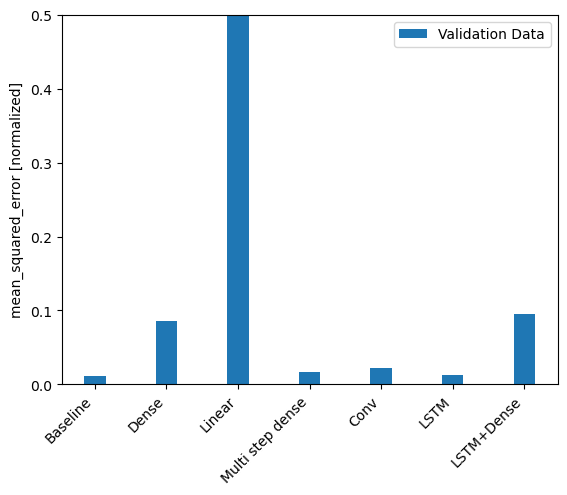

In [381]:
x = np.arange(len(val_performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mse = [v[metric_index] for v in val_performance.values()]

plt.ylabel('mean_squared_error [normalized]')
plt.bar(x, val_mse, width, label='Validation Data')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45, ha = "right")
#plt.ylim((0,0.5))
_ = plt.legend()


In [371]:
lstm_model.metrics_names

['loss',
 'mean_absolute_error',
 'mean_squared_error',
 'mean_absolute_percentage_error']

In [372]:
print(f'{"MSE":>26s}{"MAE":>9s}{"MAPE":>9s}')
for name, value in val_performance.items():
  print(f'{name:20s}: {value[metric_index]:0.4f}   {value[1]:0.4f}   {value[2]:0.4f}')


                       MSE      MAE     MAPE
Baseline            : 0.0116   0.0523   0.0116
Dense               : 0.0852   0.2652   0.0852
Linear              : 2.1678   1.3824   2.1678
Multi step dense    : 0.0166   0.1012   0.0166
Conv                : 0.0223   0.1185   0.0223
LSTM                : 0.0126   0.0706   0.0126
LSTM+Dense          : 0.0957   0.2908   0.0957


# Plot timeseries

In [373]:
def predict_with_date(self: tf.keras.Model, window: WindowGenerator, df) -> pd.DataFrame:
    model_input = window.make_dataset(df)
    predictions = self.predict(model_input, verbose = 0)
    dates = df.index[slice(window.total_window_size-1,None)]
    return pd.Series(predictions[:,predictions.shape[1]-1].flatten(), index = dates)

tf.keras.Model.predict_with_date = predict_with_date

def inverse_norm_price_p_kwh(df):
    sd = np.sqrt(norm_layer.variance[0,0])
    mean = norm_layer.mean[0,0]
    return df*sd + mean

def plot(self, window: WindowGenerator, df: pd.DataFrame):
    fig = plt.figure()
    plt.plot(
        inverse_norm_price_p_kwh(
            baseline.predict_with_date(window = window, df = df)), 
                                       label = "Baseline")
    
    plt.plot(
        inverse_norm_price_p_kwh(
        self.predict_with_date(window = window, df = df)), 
                                        label = "Predictions")
    
    plt.plot(
        inverse_norm_price_p_kwh(df["price_kwh"]), 
                                    label = "Original")
    
    plt.xticks(rotation = 45)
    plt.legend()

tf.keras.Model.plot = plot

In [374]:
window = multi_in_single_out
plot_data = val_df

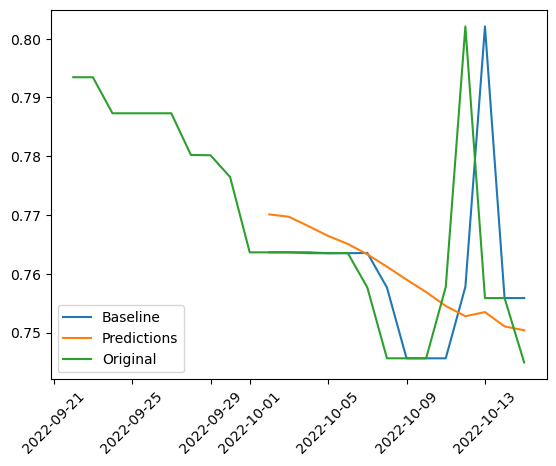

In [383]:
lstm_model.plot(window = window, df = plot_data)

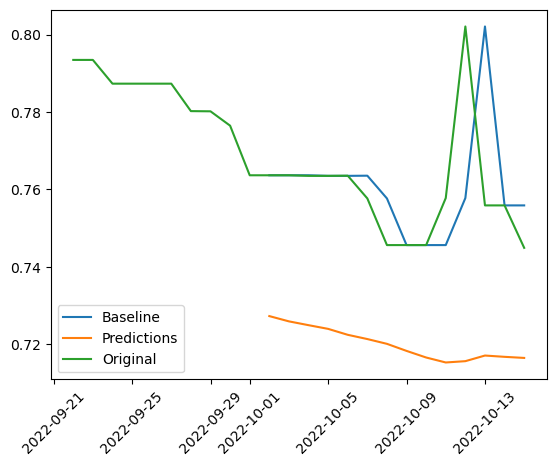

In [384]:
lstm_DNN_model.plot(window = window, df = plot_data)

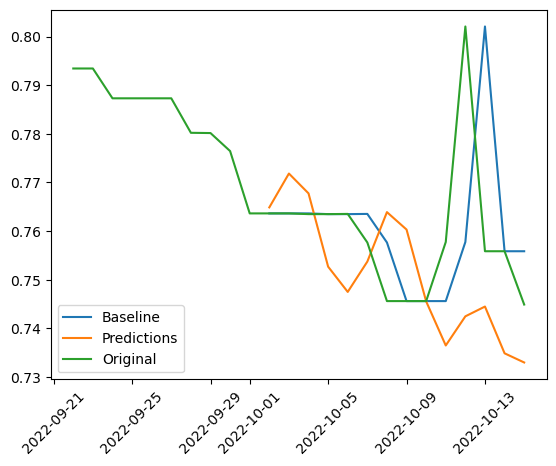

In [385]:
conv_model.plot(window, plot_data)

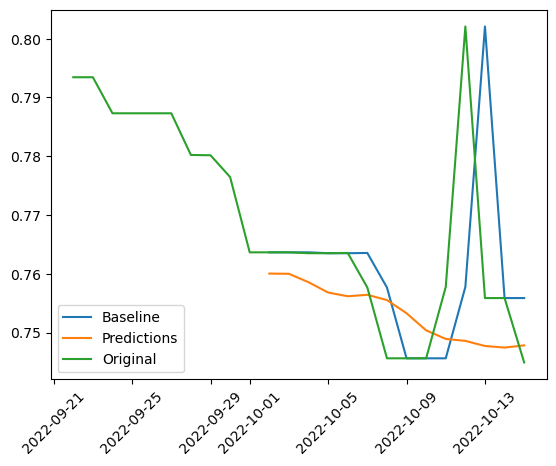

In [378]:
multi_step_dense.plot(window, plot_data)

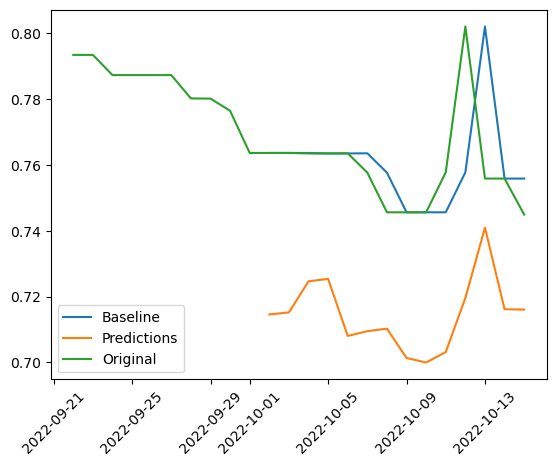

In [379]:
dense.plot(window, plot_data)

# Calculate Metrics for several Post Codes / Cons Ranges

In [ ]:
def test_tensorflow_impl(shift, consRanges, postCodes, household_data, market_data, rank_range = (6,10), input_width = 10):
    
    #columns = pd.MultiIndex.from_product([["baseline","dense","convolutional", "LSTM" ], [errormetric.name for errormetric in error_metrics]])
    models = ["baseline","dense","convolutional", "LSTM" ]
    mse_df = pd.DataFrame(index = models)
    mape_df = pd.DataFrame(index = models)
    
    for postCode in postCodes:
        for consRange in consRanges:
            
            print(postCode, consRange, end = "; ")
            
            #Data preparation and normalization
            try:
                norm_layer = tf.keras.layers.Normalization(axis = 1)
                input = queryRangePostCode(household_data, consumption_range=consRange, post_code=postCode, rank_range=rank_range)
                input = input.join(market_data[["avg_price", "moving_average"]]).interpolate(method = "time", axis = 0).dropna(axis = 0)
                norm_layer.adapt(input)
                norm_input = norm_layer(input)
                norm_input = pd.DataFrame(norm_input, columns = input.columns, index = input.index)
                train_df = norm_input[:-shift]
                val_df = norm_input[-(2*shift+input_width):]
            except:
                continue


            #Generate Windows
            single_step_window = WindowGenerator(input_width=1, label_width=1, shift=shift,
                                        label_columns=['price_kwh'], train_df=train_df, val_df=val_df)

            multi_in_single_out = WindowGenerator(input_width=input_width, label_width=1, shift=shift,
                                        label_columns=['price_kwh'], train_df=train_df, val_df=val_df)


            #Clearing of previous parameters
            tf.keras.backend.clear_session()


            #Model Declaration
            #baseline
            baseline = Baseline(label_index = 0)

            #Dense NN
            dense = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=128, activation='relu'),
                tf.keras.layers.Dense(units=64, activation='sigmoid'),
                tf.keras.layers.Dense(units=64, activation='sigmoid'),
                tf.keras.layers.Dense(units=1),
                tf.keras.layers.Reshape([1, -1]),
            ])

            #Convolutional NN with 1 Dense Layer
            conv_model = tf.keras.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=(input_width,), activation='relu'),
                tf.keras.layers.Dense(units=32, activation='relu'),
                tf.keras.layers.Dense(units=1),
            ])

            #Simple LSTM Model
            lstm_model = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.Dense(units=1)
            ])

            #create a dict for model loop and pd.Series for storing MSE and MAPE
            models = {"dense": dense, "convolutional": conv_model, "LSTM": lstm_model}

            mse_s = pd.Series(name = (postCode, consRange), dtype = np.float64)
            mape_s = pd.Series(name = (postCode, consRange), dtype = np.float64)

            
            #Fit Models
            baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=error_metrics)
            
            mse_s["baseline"], mape_s["baseline"] = baseline.evaluate(single_step_window.val, verbose = 0)
            
            
            for name, model in models.items():
                history = compile_and_fit(model, multi_in_single_out)
                mse_s[name], mape_s[name]  = model.evaluate(multi_in_single_out.val, verbose = 0)

            
            #Store MSE and MAPE Values in DFs
            mse_df = pd.concat([mse_df, mse_s], axis = 1)
            mape_df = pd.concat([mape_df, mape_s], axis = 1)

    return mse_df.T, mape_df.T

In [414]:
consRanges_test_models = consRanges[(consRanges<=5000) & (consRanges>=3000)]
postCodes_test_models = postCodes[43:47]
rank_range = (6,10)

print(consRanges_test_models, postCodes_test_models)
print(f"{np.count_nonzero(consRanges_test_models)*np.count_nonzero(postCodes_test_models)} calculations to be done")

[3500 3000 4000 4500 5000 4250 3600] ['46238' '47798' '55118' '53229']
28 calculations to be done


In [ ]:

mse_tensorflow_df, mape_tensorflow_df = test_tensorflow_impl(shift = shift, 
                                input_width=input_width, 
                                consRanges=consRanges_test_models, 
                                postCodes=postCodes_test_models,
                                rank_range=rank_range,
                                household_data=household,
                                market_data=market_data)


In [408]:
mape_tensorflow_df.describe()

,baseline,dense,convolutional,LSTM
count,28.000000,28.000000,28.000000,28.000000
mean,4.651255,17.108397,10.937198,3.367585
std,0.336317,10.427432,6.459199,1.885085
min,4.122550,10.546396,1.321261,0.163478
25%,4.410775,13.526323,5.055388,1.953060
50%,4.570435,14.914761,10.484369,3.329395
75%,4.920659,17.537580,15.274448,4.496819
max,5.268321,68.519989,24.583452,6.593685


In [407]:
mse_tensorflow_df.describe()

,baseline,dense,convolutional,LSTM
count,28.000000,28.000000,28.000000,28.000000
mean,0.033793,0.151559,0.061777,0.006400
std,0.005115,0.321738,0.061794,0.005215
min,0.021251,0.040944,0.000865,0.000012
25%,0.030550,0.068143,0.012387,0.001746
50%,0.034855,0.090444,0.042196,0.006359
75%,0.037118,0.115979,0.090197,0.011165
max,0.041895,1.785194,0.234939,0.016295


# Cut

In [1]:
from darts.metrics import mape, mse
from darts.models import RegressionModel, BlockRNNModel, NaiveSeasonal
from darts import utils, TimeSeries
from darts.dataprocessing.transformers import Scaler
from func_test_models import test_darts_impl, test_tensorflow_impl

In [416]:
def eval_linear_model(model, target, covariates, days = 1, train_size = 0.8):

    #Defining test dataset
    p_train, _ = target.split_before(train_size)
    model.fit(p_train, past_covariates= covariates)
        
    # We backtest the model on the last part of the timeseries:
    backtest = model.historical_forecasts(series=target, 
                                            past_covariates=covariates,
                                            start=train_size, 
                                            retrain=True,
                                            verbose=False, 
                                            forecast_horizon=days)
    return mape(target, backtest)


def evaluate_models(target, covariates, lags, lags_covs, days = 1, train_size = 0.80):
    days = max(days, 1)
    best_score, best_cfg = float("inf"), None
    for l in lags:
        for c in lags_covs:
            try:
                reg_model = RegressionModel(lags = l, lags_past_covariates= c, output_chunk_length=days)
                mape = eval_linear_model(reg_model, target, covariates, days, train_size)
                if mape < best_score:
                    best_score, best_cfg = mape, (l, c)
            except:
                print('error in model eval')
                continue
    print('Best ModelA%s MAPE=%.6f' % (best_cfg, best_score))
    return best_cfg

def scaleTimeSeries(timeseries):
    scaler = Scaler()
    series_scaled = scaler.fit_transform(timeseries)
    return series_scaled

In [422]:
def test_darts_impl(shift, consRanges, postCodes, household_data, market_data, rank_range = (6,10)):

    models = ["baseline","LSTM","regression"]
    mse_df = pd.DataFrame(index = models)
    mape_df = pd.DataFrame(index = models)

    for postCode in postCodes:
        for consRange in consRanges:
            
            print(postCode, consRange, end = "; ")

            #Querying dataset
            df = queryRangePostCode(rank_range = rank_range, post_code=postCode, consumption_range=consRange, df_power=household_data)
            
            if not df.shape[0]:
                print('No data found.')
                continue

            #Shifting prices by 1 to avoid look-ahead bias
            real_prices = df.price_kwh
            df = df.shift(1)
            df.price_kwh = real_prices

            #Merging price data
            df = df.join(market_data)

            #Adding rolling moving average as additional covariate
            df['moving_average'] = df.avg_price.ewm(alpha=0.1, adjust=False).mean()

            #Dropping resulting NA column
            df.dropna(inplace=True)
            
            ##Building TimeSeries objects, and filling in missing date indices
            past_covs = utils.missing_values.fill_missing_values(TimeSeries.from_dataframe(df[['avg_price', 'moving_average']], fill_missing_dates= True))
            prices = utils.missing_values.fill_missing_values(TimeSeries.from_dataframe(df[['price_kwh']], fill_missing_dates= True))

            #Scaling both timeseries
            past_covs = scaleTimeSeries(past_covs)
            prices = scaleTimeSeries(prices)

            #Defining train datasets
            past_covs_train = past_covs[:-shift]
            prices_train = prices[:-shift]
            prices_valid = prices[-shift:]

            #Defining hyperparam grid for linear regression model
            lags = [1,2,3,4,5]
            cov_lags = [1,2,3,4,5]

            #Finding optimal lags
            l, c = evaluate_models(prices_train, past_covs_train, lags, cov_lags, shift)

            #Defining Benchmark
            benchmark = NaiveSeasonal(K=1)
            benchmark.fit(prices_train)
            bm = benchmark.predict(shift)


            #Fit and predict Models 
            reg_model = RegressionModel(l, c, output_chunk_length=shift)
            reg_model.fit(prices_train, past_covs_train)
            rnn_model = BlockRNNModel(model="LSTM", n_epochs=20, random_state=42, input_chunk_length= 1, output_chunk_length=shift)
            rnn_model.fit(prices_train, past_covariates=past_covs_train, verbose = False)
            preds_rnn = rnn_model.predict(shift, series = prices_train, past_covariates= past_covs_train)
            preds_reg = reg_model.predict(shift, series = prices_train, past_covariates= past_covs_train)


            mse_s = pd.Series(name = (postCode, consRange), dtype = np.float64)
            mape_s = pd.Series(name = (postCode, consRange), dtype = np.float64)


            mape_s["LSTM"] = mape(preds_rnn, prices_valid)
            mape_s["regression"] = mape(preds_reg, prices_valid)
            mape_s["baseline"] = mape(bm, prices_valid)

            mse_s["LSTM"] = mse(preds_rnn, prices_valid)
            mse_s["regression"] = mse(preds_reg, prices_valid)
            mse_s["baseline"] = mse(bm, prices_valid)

            #Store MSE and MAPE Values in DFs
            mse_df = pd.concat([mse_df, mse_s], axis = 1)
            mape_df = pd.concat([mape_df, mape_s], axis = 1)

    
    return mse_df.T, mape_df.T

In [ ]:

mse_darts_df, mape_darts_df = test_darts_impl(shift = shift, 
                                consRanges=consRanges_test_models, 
                                postCodes=postCodes_test_models,
                                household_data=household,
                                market_data=market_data,
                                rank_range=rank_range)


In [424]:
mape_darts_df.describe()

,baseline,LSTM,regression
count,28.0,28.000000,28.000000
mean,0.0,1.736733,1.570565
std,0.0,0.390016,0.586608
min,0.0,1.033151,0.672131
25%,0.0,1.416092,1.115775
50%,0.0,1.859008,1.473004
75%,0.0,2.020265,2.091430
max,0.0,2.324475,2.605242


In [425]:
mse_darts_df.describe()

,baseline,LSTM,regression
count,28.0,28.000000,28.000000
mean,0.0,0.000226,0.000202
std,0.0,0.000090,0.000138
min,0.0,0.000079,0.000035
25%,0.0,0.000142,0.000092
50%,0.0,0.000238,0.000147
75%,0.0,0.000293,0.000321
max,0.0,0.000363,0.000501
